## LOAN DEFAULT PREDICTION
Building a machine learning model that predicts whether a customer will default in a loan or not

#### 1.0 Import Dependencies & Dataset

In [1]:
#Importing libraries

import re
import pandas as pd
import numpy as np
import warnings
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_column", None)
pd.set_option("display.max_row", None)
%matplotlib inline

In [2]:
#Import the Dataset into a Dataframe

df_copy = pd.read_csv("Financial data.csv")

In [3]:
# Copy Dataset for safety

df = df_copy.copy()

#### 1.1 Data Exploration

In [4]:
print(df.shape)
df

(58, 6)


,Customer ID,Annual income,Credit score,Employment length,Debt-to-income ratio,Loan default
0,1,"$65,000",680,2 years,0.24,0.0
1,2,"$40,000",590,1 year,0.37,1.0
2,3,"$95,000",720,5 years,0.16,0.0
3,4,"$35,000",530,6 months,0.50,1.0
4,5,"$80,000",710,4 years,0.27,0.0
5,6,"$55,000",650,3 years,0.32,0.0
6,7,"$100,000",750,6 years,0.15,0.0
7,8,"$45,000",600,1 year,0.42,1.0
8,9,"$110,000",790,7 years,0.12,0.0
9,10,"$75,000",700,3 years,0.28,0.0


In [5]:
df.describe()

,Customer ID,Credit score,Debt-to-income ratio,Loan default
count,58.000000,58.000000,57.000000,57.000000
mean,29.500000,674.310345,0.296667,0.298246
std,16.886879,80.461652,0.116792,0.461555
min,1.000000,520.000000,0.110000,0.000000
25%,15.250000,610.000000,0.200000,0.000000
50%,29.500000,695.000000,0.280000,0.000000
75%,43.750000,730.000000,0.380000,1.000000
max,58.000000,800.000000,0.520000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer ID           58 non-null     int64  
 1   Annual income         57 non-null     object 
 2   Credit score          58 non-null     int64  
 3   Employment length     57 non-null     object 
 4   Debt-to-income ratio  57 non-null     float64
 5   Loan default          57 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 2.8+ KB


##### Issues discovered with the dataset

- The column headers are inappropriate
- The `Annual income` column contains currency symbols and comma therefore it is an object data type.
- The `Employment length` column contains both numbers and strings therefore it is an object data type.
- The `Employment length`,`Debt-to-income ratio`,`Loan default` columns have a missing row of data.

In [7]:
df.groupby('Employment length')["Loan default"].value_counts().sort_values()

Employment length  Loan default
2 years            1.0             2
7 years            0.0             4
6 years            0.0             5
2 years            0.0             6
6 months           1.0             6
5 years            0.0             7
4 years            0.0             8
1 year             1.0             9
3 years            0.0             9
Name: Loan default, dtype: int64

- The highest defaulters are those who have spent just 1 year in the company followed by 2 years of employment length.

- The highest number of those who dont default are those who have spent 3 years in the company.

#### 1.2 Data Cleaning

##### 1. Change the Column Headers to appropraite headers.

In [8]:
df.rename(columns={"Customer ID":"customer_id","Annual income":"annual_income","Credit score":"credit_score","Employment length":
                   "employment_length","Debt-to-income ratio":"debt_to_income_ratio","Loan default":"loan_default"},inplace=True)

In [9]:
# Confirm success

df.head()

,customer_id,annual_income,credit_score,employment_length,debt_to_income_ratio,loan_default
0,1,"$65,000",680,2 years,0.24,0.0
1,2,"$40,000",590,1 year,0.37,1.0
2,3,"$95,000",720,5 years,0.16,0.0
3,4,"$35,000",530,6 months,0.50,1.0
4,5,"$80,000",710,4 years,0.27,0.0


##### 2. Remove the symbols and comma in the `annual_income` column and convert to the correct datat type

In [10]:
df["annual_income"] = df["annual_income"].replace('[\$,]','', regex= True)

df["annual_income"] = df["annual_income"].astype('float64')

In [11]:
# Confirm success

df.head()

,customer_id,annual_income,credit_score,employment_length,debt_to_income_ratio,loan_default
0,1,65000.0,680,2 years,0.24,0.0
1,2,40000.0,590,1 year,0.37,1.0
2,3,95000.0,720,5 years,0.16,0.0
3,4,35000.0,530,6 months,0.50,1.0
4,5,80000.0,710,4 years,0.27,0.0


##### 3. Remove the string in the `employment_length` column

In [12]:
for i in range(0, len(df["employment_length"])):
    try:
        df["employment_length"][i] = df["employment_length"][i].split(' ')[0]
    except:
        pass

In [13]:
# convert to correct data type

df["employment_length"] = df["employment_length"].astype('float64')

In [14]:
# Confirm success

df.head()

,customer_id,annual_income,credit_score,employment_length,debt_to_income_ratio,loan_default
0,1,65000.0,680,2.0,0.24,0.0
1,2,40000.0,590,1.0,0.37,1.0
2,3,95000.0,720,5.0,0.16,0.0
3,4,35000.0,530,6.0,0.50,1.0
4,5,80000.0,710,4.0,0.27,0.0


4. Fix the missing data in the following columns
    - `annual_income`
    - `employment_length`
    - `debt_to_income_ratio`
    - `loan_default`

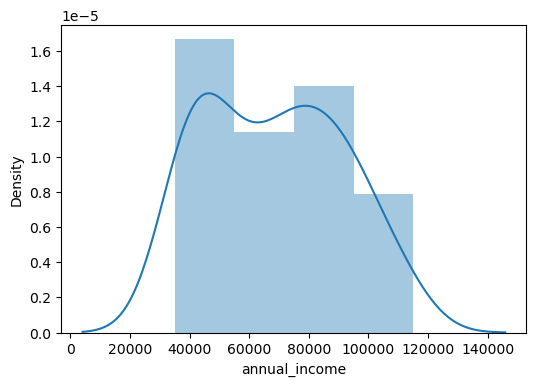

In [15]:
# check the distribution of annual_income column

fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(df.annual_income);

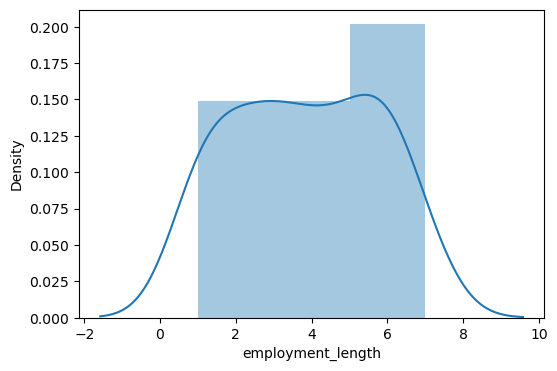

In [16]:
# check the distribution of employment_length column
fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(df.employment_length);

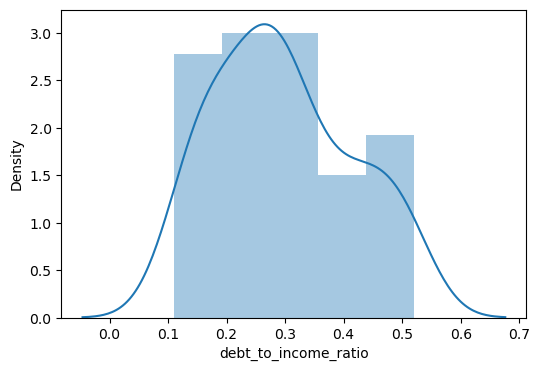

In [17]:
# check the distribution of debit_to_income_ratio column
fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(df.debt_to_income_ratio);

In [18]:
# Since the `Loan` default column is a numerical column with only two unique values, fill using the mode

df["loan_default"] = df["loan_default"].fillna(df["loan_default"].mode()[0])

In [19]:
# Confirm success

df.loan_default.isnull().sum()

0

In [20]:
# since the columns are not skewed, fill using the mean

df = df.fillna(df.mean())

In [21]:
# Convert columns that should be int data type

df["annual_income"] = df["annual_income"].astype('int64')
df["employment_length"] = df["employment_length"].astype('int64')
df["loan_default"] = df["loan_default"].astype('int64')

In [22]:
# Confirm success

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           58 non-null     int64  
 1   annual_income         58 non-null     int64  
 2   credit_score          58 non-null     int64  
 3   employment_length     58 non-null     int64  
 4   debt_to_income_ratio  58 non-null     float64
 5   loan_default          58 non-null     int64  
dtypes: float64(1), int64(5)
memory usage: 2.8 KB


In [23]:
df

,customer_id,annual_income,credit_score,employment_length,debt_to_income_ratio,loan_default
0,1,65000,680,2,0.240000,0
1,2,40000,590,1,0.370000,1
2,3,95000,720,5,0.160000,0
3,4,35000,530,6,0.500000,1
4,5,80000,710,4,0.270000,0
5,6,55000,650,3,0.320000,0
6,7,100000,750,6,0.150000,0
7,8,45000,600,1,0.420000,1
8,9,110000,790,7,0.120000,0
9,10,75000,700,3,0.280000,0


#### Check the Multi-dimensionalism of the dataset

In [24]:
df.nunique()

customer_id             58
annual_income           24
credit_score            25
employment_length        7
debt_to_income_ratio    32
loan_default             2
dtype: int64

#### Finding:
- All values in the `customer_id` column are unique therefore should be dropped

In [25]:
df.drop(columns="customer_id", inplace=True)

#### Check the distribution of out target column `loan_default`

In [26]:
df.loan_default.value_counts(normalize=True) * 100

0    70.689655
1    29.310345
Name: loan_default, dtype: float64

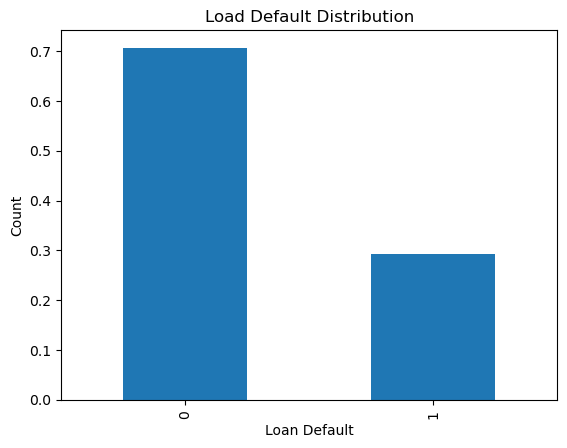

In [27]:
# Vizualise the distribution

df.loan_default.value_counts(normalize=True).plot(
    kind= "bar",
    xlabel= "Loan Default",
    ylabel= "Count",
    title= "Load Default Distribution"
);

#### Finding

The data is impalanced and can introduce bias to our model as it will see a very high number of No defaulters.

- To fix this we will do Oversampling to have a balanced dataset, this will be done after splitting

#### Lets check for Multicullinearity by looking at the Confusion Matrix

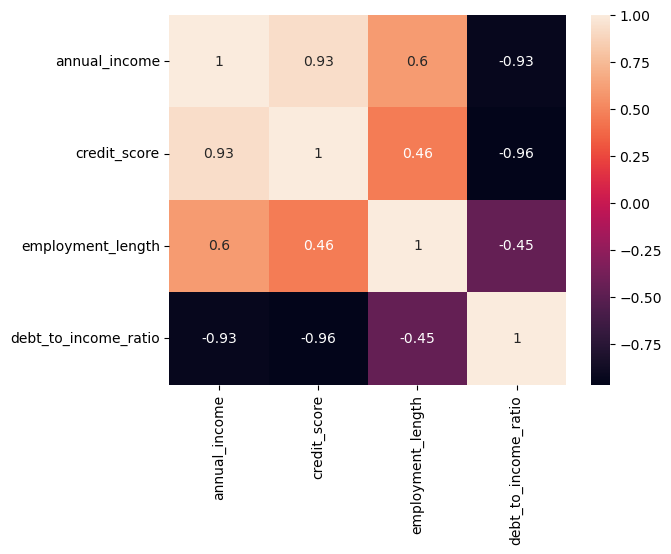

In [28]:
df_corr = df.drop(columns="loan_default").corr()
sns.heatmap(df_corr, annot=True);

#### Findings:

- There are high correlation between the following columns:
    - `annual_income` and `credit_score`
    - `annual_income` and `employment_length`
    - `credit_score` and `employment_length`
    
To fix this issue of multicullinearity, we will use the dimensionality reduction technique PCA. This will be done after splitting

### Model Building

#### Split the Dataset

In [29]:
# Vertical Split

X = df.drop(columns="loan_default")
y = df.loan_default

In [30]:
X.head()

,annual_income,credit_score,employment_length,debt_to_income_ratio
0,65000,680,2,0.24
1,40000,590,1,0.37
2,95000,720,5,0.16
3,35000,530,6,0.50
4,80000,710,4,0.27


In [31]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: loan_default, dtype: int64

#### Performing PCA

In [32]:
pca = PCA(n_components=None)

X_pca = pca.fit_transform(X)

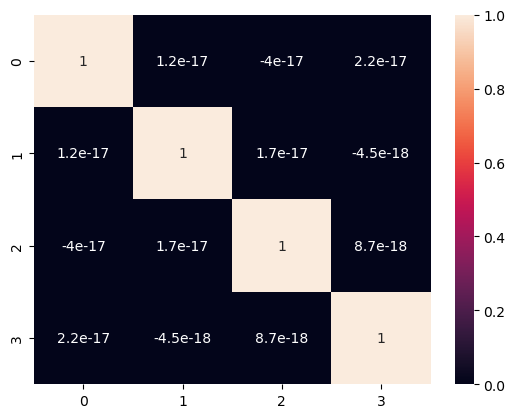

In [33]:
X_pca = pd.DataFrame(X_pca)
sns.heatmap(X_pca.corr(), annot=True);

In [34]:
# Horinzontal Split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [35]:
print(f"X_train shape{X_train.shape}")
print(f"X_test shape{X_test.shape}")
print(f"y_train shape{y_train.shape}")
print(f"y_test shape{y_test.shape}")

X_train shape(46, 4)
X_test shape(12, 4)
y_train shape(46,)
y_test shape(12,)


In [36]:
# Scale the train dataset first using the standard scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Performing Over sampling to fix the imbalanced dataset

In [37]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train_scaled, y_train)

In [38]:
X_train_over = pd.DataFrame(X_train_over)
print(X_train_over.shape)
X_train_over.head()

(68, 4)


,0,1,2,3
0,-1.589903,-1.674454,1.484343,1.071361
1,1.318995,0.335135,-1.367447,0.426873
2,1.766512,-0.781158,-0.582915,-0.176077
3,-0.918615,-0.259292,1.548528,0.833568
4,1.318989,-1.037468,-0.103989,-1.124971


In [39]:
y_train_over.value_counts(normalize=True)

1    0.5
0    0.5
Name: loan_default, dtype: float64

#### Build Model

Logistic Regression

Baseline Model

In [40]:
acc_baseline = y_train_over.value_counts(normalize=True).max()
print("Baseline Accuracy: ", round(acc_baseline,2))

Baseline Accuracy:  0.5


In [41]:
# Buid model

model = LogisticRegression()

# Fit the model

model.fit(X_train_over, y_train_over)

LogisticRegression()

In [42]:
# Generate predictions using the fitted model

pred = model.predict(X_test)

In [43]:
# Check the accuracy score of the model

accuracy_score(pred, y_test)

0.75

#### Check the AUC-ROC score

In [44]:
pred_prob = model.predict_proba(X_test)

In [45]:
roc_auc_score(y_test, pred_prob[:, 1])

0.7857142857142857

#### Ploting the Confusion Matrix

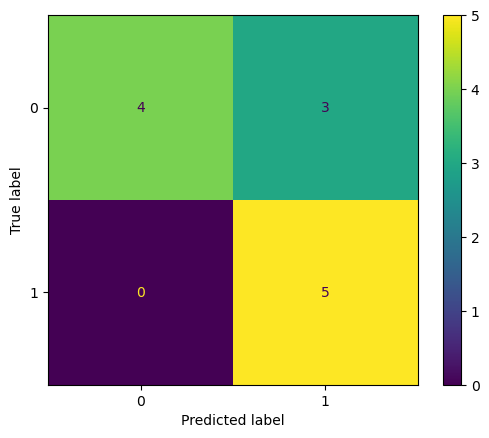

In [46]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

#### Check the Precision and recall

In [47]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.62      1.00      0.77         5

    accuracy                           0.75        12
   macro avg       0.81      0.79      0.75        12
weighted avg       0.84      0.75      0.74        12



#### Save the trained model for future use

In [48]:
# Save your model as "model_Logistic_regression"

with open("model_Logistic_regression", "wb") as f:
    pickle.dump(model, f)